# Import Libraries

In [1]:
!pip install pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 8.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.4
    Uninstalling tensorflow-2.6.4:
      Successfully uninstalled tensorflow-2.6.4
ERROR: pip's dependency resolver does not cu

In [2]:
!pip install cirq==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.

In [294]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [73]:
# load our data
data = pd.read_csv("../input/emotion-prediction-with-semi-supervised-learning/tweet_emotions.csv")
plt.style.use('fivethirtyeight')

# Data Visualization

<AxesSubplot:xlabel='count', ylabel='sentiment'>

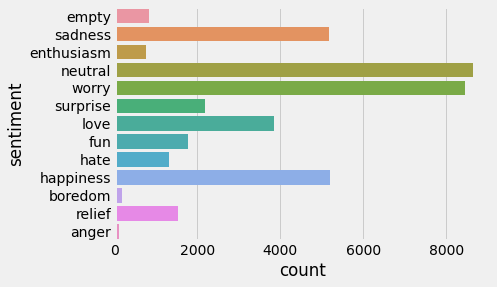

In [74]:
sns.countplot(y=data["sentiment"])

# Data Cleanup and Prepare

In [75]:
stop_words = set(stopwords.words('english'))
from nltk.stem import RegexpStemmer
snowball = RegexpStemmer('ing$|s$|e$|able$', min=4)

data["content"] = data["content"].apply(lambda x: " ".join([snowball.stem(re.sub(r'[^\w\d]', "", word)) for word in x.lower().split() if word not in stop_words]))

X = data["content"]
tokenize = Tokenizer()

tokenize.fit_on_texts(X)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
X = pad_sequences(tokenize.texts_to_sequences(X), maxlen=max_length, padding="post")

# Preparation of Quantum5

In [194]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(2)
clayer2 = tf.keras.layers.Dense(13, activation="softmax")
model = tf.keras.models.Sequential([clayer1, qlayer, clayer2])
opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(opt, loss='mae')

# Preparation of Label

In [143]:
Y = data['sentiment']
from sklearn.preprocessing import LabelEncoder

func = LabelEncoder()

Y = func.fit_transform(Y)
Y = tf.convert_to_tensor(Y)

X = tf.constant(X)
Y = tf.one_hot(Y, depth=1)

# Model Fitting

In [195]:
model.fit(X,Y, epochs=1, batch_size=256, shuffle=True,steps_per_epoch=1,validation_split=0.1)

1/1 [==============================] - 202s 202s/step - loss: 0.0802 - val_loss: 0.0773


# Preparation of Prediction Data and Prediction Equation

In [289]:
a = "Yes, I am very normal!"
tokenize.fit_on_texts(a)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
a = pad_sequences(tokenize.texts_to_sequences(a), maxlen=max_length, padding="post")

In [290]:
a = tf.constant(a)
prediction = model.predict(a)

In [291]:
ap = []
for i in range(len(prediction)):
    ap.append(np.argmax(prediction[i]))
np.argmax(ap)

8

In [292]:
result = np.argmax(ap)
result = np.array(result).reshape(1)

In [293]:
func.inverse_transform(result)

array(['neutral'], dtype=object)